In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/', '')
  
import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import algos_factory
from deepiu.seq2seq.rnn_decoder import SeqDecodeMethod

#debug
from deepiu.util import text2ids

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'

#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.keywords.finetune/'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.keywords.fetch.finetune/'
FLAGS.model_dir = model_dir

net = melt.image.get_imagenet_from_checkpoint(FLAGS.image_checkpoint_file)
print('image net', net, 'net.default_image_size', net.default_image_size)
FLAGS.image_model_name = FLAGS.image_model_name or net.name
FLAGS.image_height = FLAGS.image_height or net.default_image_size
FLAGS.image_width = FLAGS.image_width or net.default_image_size
image_model_name = FLAGS.image_model_name
if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, feature_name='attention')
else:
  image_model = None
print('image_model', image_model)


import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.4.0-rc1


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
image net <function inception_resnet_v2 at 0x7f704e3e1ed8> net.default_image_size 299
image_model None


ENCODE_UNK 1


In [2]:
if 'coverage' in model_dir:
  FLAGS.coverage_attention_wrapper = True

FLAGS.image_encoder = 'Rnn'
FLAGS.showtell_encode_scope = 'encode'
FLAGS.showtell_decode_scope = 'decode'
FLAGS.image_endpoint_feature_name = 'attention'
FLAGS.image_checkpoint_file = image_model_checkpoint_path 
FLAGS.pre_calc_image_feature = False 
FLAGS.finetune_image_model = True 
FLAGS.image_features_batch_norm = True 
FLAGS.emb_dim = 512 
FLAGS.rnn_hidden_size = 512 
FLAGS.alignment_history = True

FLAGS.image_attention_size = FLAGS.image_attention_size or melt.image.get_num_features(FLAGS.image_model_name)
FLAGS.image_feature_len = FLAGS.image_feature_len or melt.image.get_feature_dim(FLAGS.image_model_name) * FLAGS.image_attention_size

beam_size = 10
length_normalization_factor = 1.
decode_max_words = 3

In [3]:
algo = 'show_and_tell'
global_scope = algo
main_scope = 'main'
melt.apps.image_processing.init()
with tf.variable_scope(global_scope):
  with tf.variable_scope(main_scope):
    predictor =  algos_factory.gen_predictor(algo)
    predictor.init_predict_text(decode_method=SeqDecodeMethod.ingraph_beam, 
                                beam_size=beam_size,
                                length_normalization_factor=length_normalization_factor,
                                logprobs_history=True,
                                alignment_history=True,
                                max_words=5)   #include done token 

predictor.load(FLAGS.model_dir) 

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
rnn decoder gen only mode
preprocessing_fn net_name inception_resnet_v2 height 299 width 299
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("show_and_tell/main/encode/Flatten/flatten/Reshape:0", shape=(?, 98304), dtype=float32)
use melt.seq2seq.CoverageBahdanauAttention


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.keywords.fetch.finetune/model.ckpt-56.45-83400


restore ok: /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.keywords.fetch.finetune/model.ckpt-56.45-83400
load model ok /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.keywords.fetch.finetune/model.ckpt-56.45-83400 duration: 39.2504799366


In [4]:
def simple_predict(image_path, predictor):
  timer = gezi.Timer('beam search using time')
  img = melt.read_image(image_path)
  if image_model:
    #attention model gen features only
    feature = image_model.gen_features(img) if image_model is not None else img
  else:
    feature = [img]    
  #texts_list, scores_list = predictor.predict_text(feature)
  #timer.print()
  logprobs_history = None 
  alignment_history = None

  l = predictor.predict_text(feature)
  timer.print()
  texts_list, scores_list= l[0], l[1]
  try:
    logprobs_history = l[2]
    alignment_history = l[3]
  except Exception:
    pass

  #print(alignment_history)

  texts = texts_list[0]
  scores = scores_list[0]
  if logprobs_history is not None:
    logprobs = logprobs_history[0]
  else:
    logprobs = [None] * len(texts)
  if alignment_history is not None:
    alignments = alignment_history[0]
  else:
    alignments = [None] * len(texts)
    
  logprob = None 
  alignment = None 
    
  for text, score, logprob, alignment in zip(texts, scores, logprobs, alignments):
    print('align shape', alignment.shape)
    print(ids2text.ids2text(text), score)
    print(text, len(text))
    if logprob is not None:
      print(map(math.exp, logprob))
    #if alignment is not None:
    #  print(alignment)
    #  print(alignment[10], alignment[11], alignment[12])


In [5]:
#simple_predict(image_path, predictor)

In [6]:
def predict(image_path, predictor, length_normalization_factor=0.25, num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  texts, scores, logprobs_history, alignment_history = predictor.predict_text(feature)
  for i, (text, score, logprob, alignment) in enumerate(zip(texts[0], scores[0], logprobs_history[0], alignment_history[0])):
    print(i, ids2text.ids2text(text), score)
    #print(alignment)

    # Plot images with attention weights
    words = ids2text.ids2words(text) 
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 10:  
      print('probs', [math.exp(x) for x in logprob])
      for j in range(len(words)):
        #if i == 0:
        #  print(i, j, words[j], alignment[j])
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(words[j].decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(logprob[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(alignment[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(alignment[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

  print('beam search using time(ms):', timer.elapsed_ms())

In [ ]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 743e12038dcf7dbc68123ca7dff9d6d66eb09ea1


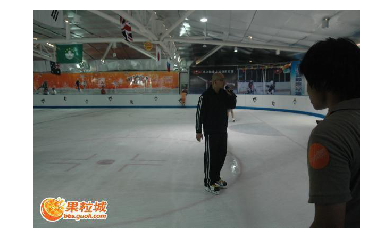

0 大厅 制服 </S> 0.0170469
probs [0.12338469107605476, 0.1134975654339459, 0.00035374146491191905, 0.0, 0.0]


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


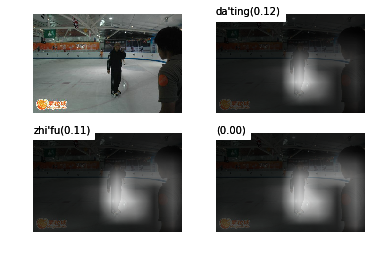

1 大厅 交谈 </S> 0.0116736
probs [0.12338469107605476, 0.040075255982059785, 0.00032172179159366536, 0.0, 0.0]


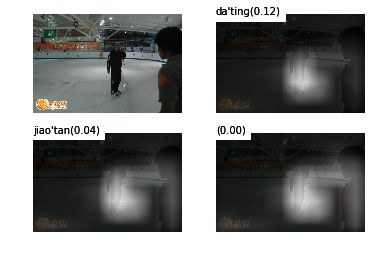

2 大厅 制服 交谈 </S> 0.00975154
probs [0.12338469107605476, 0.1134975654339459, 0.057419731685225815, 1.1245643519651812e-05, 0.0]


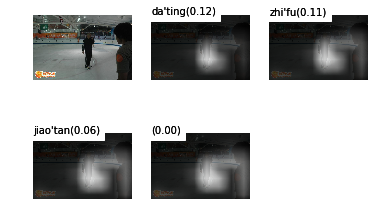

3 地铁站 制服 大厅 </S> 0.00974837
probs [0.07319425618202735, 0.06931041277086762, 0.11451091068001334, 1.55455172117481e-05, 0.0]


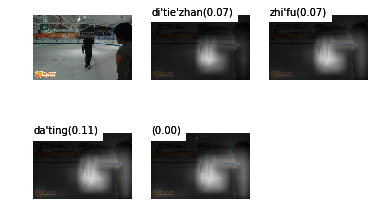

4 大厅 制服 制服 </S> 0.00964989
probs [0.12338469107605476, 0.1134975654339459, 0.0454276416655812, 1.3630776920494601e-05, 0.0]


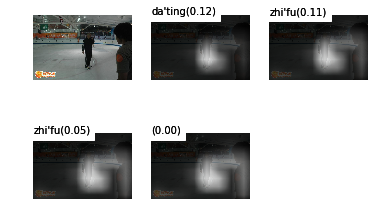

5 制服 大厅 </S> 0.00940162
probs [0.07188336120310011, 0.08137514875650956, 0.00014206521866094675, 0.0, 0.0]


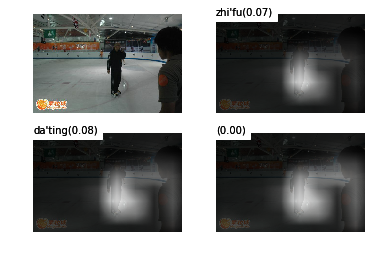

6 制服 制服 大厅 </S> 0.00932591
probs [0.07188336120310011, 0.08681542908685794, 0.0759058068679467, 1.5968488207101634e-05, 0.0]


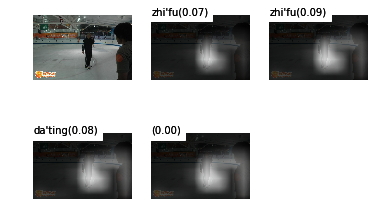

7 地铁站 大厅 </S> 0.009155
probs [0.07319425618202735, 0.09056591325897147, 0.00011575336813186362, 0.0, 0.0]


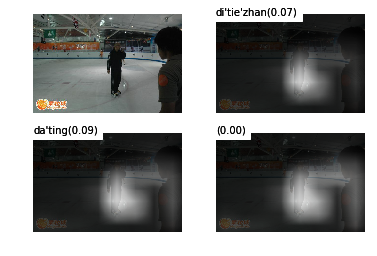

8 保龄球 制服 大厅 </S> 0.00905955
probs [0.05496098935069047, 0.07052115141100042, 0.11102689740215767, 1.5653940795064852e-05, 0.0]


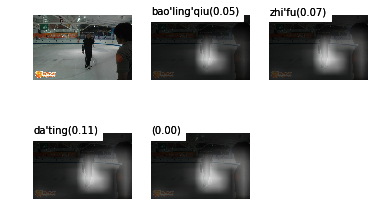

9 大厅 制服 走 </S> 0.00885548
probs [0.12338469107605476, 0.1134975654339459, 0.04523521890058707, 9.707885918230013e-06, 0.0]


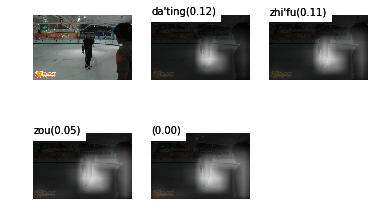

beam search using time(ms): 5086.12799644
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 0d5bb5c1fcebec433bdd5a636c85e907d0d40535


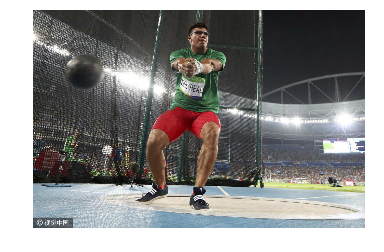

0 跑道 跑道 </S> 0.0136399
probs [0.1255885757951632, 0.15116091058333933, 0.00013367421087345216, 0.0, 0.0]


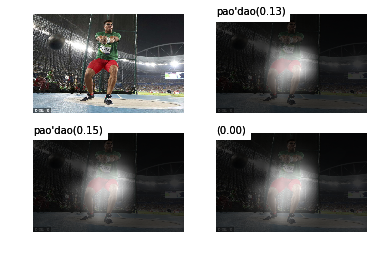

1 跑步 跑道 运动服 运动场 </S> 0.0132068
probs [0.059073572265170037, 0.23606995011907628, 0.10029832106948963, 0.14524852902357843, 1.977676598803834e-06]


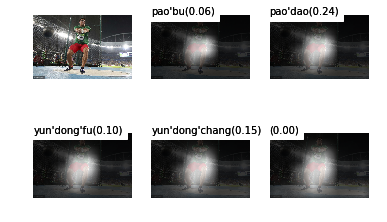

2 跑道 跑道 跑步 </S> 0.0122209
probs [0.1255885757951632, 0.15116091058333933, 0.10144802069349716, 1.158184582272631e-05, 0.0]


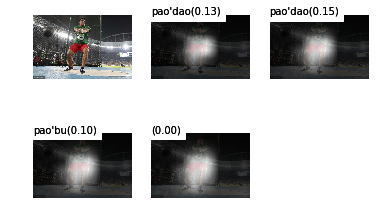

3 举重 跑道 跑步 </S> 0.0120579
probs [0.11439692896014349, 0.12751656019631513, 0.10720882885297853, 1.3516938908890784e-05, 0.0]


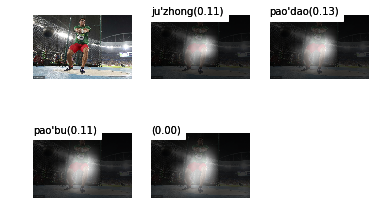

4 举重 跑道 </S> 0.0118912
probs [0.11439692896014349, 0.12751656019631513, 0.0001152647079598128, 0.0, 0.0]


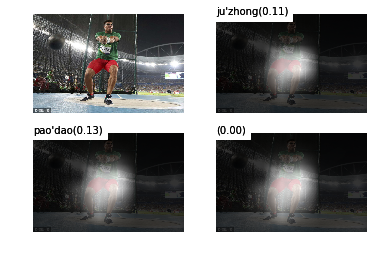

5 跑步 跑道 跑道 运动服 </S> 0.0117895
probs [0.059073572265170037, 0.23606995011907628, 0.07555507854206107, 0.09547719142955743, 2.264044430974545e-06]


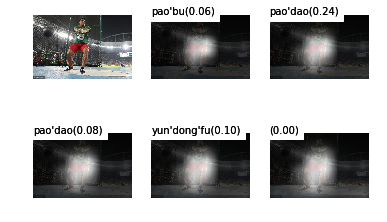

6 跑道 跑步 </S> 0.0117376
probs [0.1255885757951632, 0.10377302851696665, 0.00012407892950069724, 0.0, 0.0]


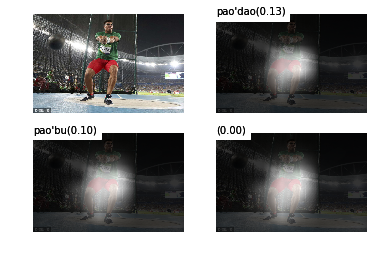

7 跑步 跑道 运动服 红色 </S> 0.0113871
probs [0.059073572265170037, 0.23606995011907628, 0.10029832106948963, 0.06898413904383138, 1.9841715126704338e-06]


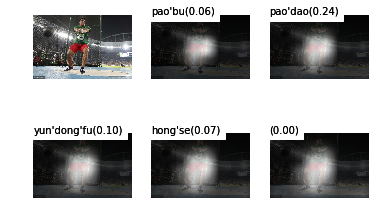

8 跑道 跑道 跑步 运动服 </S> 0.0113503
probs [0.1255885757951632, 0.15116091058333933, 0.10144802069349716, 0.06253121034546837, 1.5642441909378507e-06]


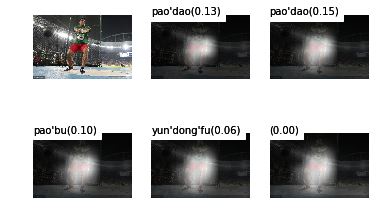

9 跑步 跑道 运动服 跑道 </S> 0.0113184
probs [0.059073572265170037, 0.23606995011907628, 0.10029832106948963, 0.07380076476999209, 1.799426414350013e-06]


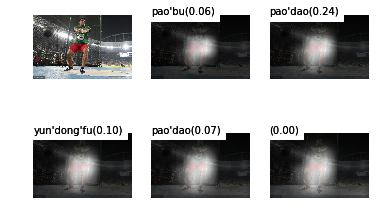

beam search using time(ms): 6626.8799305
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 0aa9bd2851ea3cb45d99247ae9d9e7185036474c.jpg


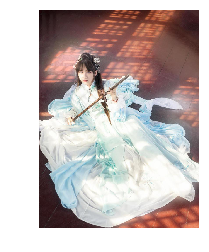

0 小提琴 表演 舞台 </S> 0.0212302
probs [0.31076324063790517, 0.09004998660923544, 0.19621379757916008, 3.699766900099157e-05, 0.0]


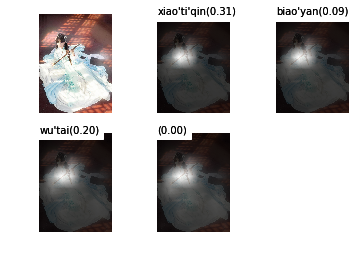

1 小提琴 拉 舞台 </S> 0.02033
probs [0.31076324063790517, 0.08870607178099203, 0.16241174769890843, 3.8154813218170085e-05, 0.0]


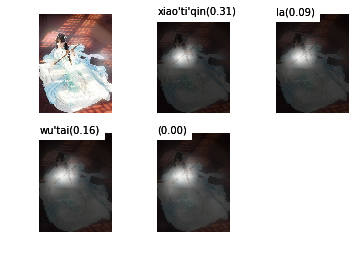

2 小提琴 舞台 </S> 0.0203076
probs [0.31076324063790517, 0.08260748655078472, 0.0003262335959829478, 0.0, 0.0]


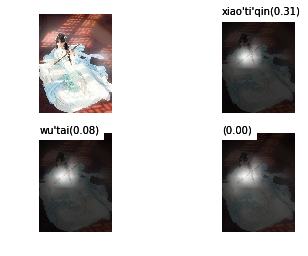

3 笛子 表演 舞台 </S> 0.0188954
probs [0.19404586777067057, 0.08855563850141208, 0.20029616203172043, 3.703674871137768e-05, 0.0]


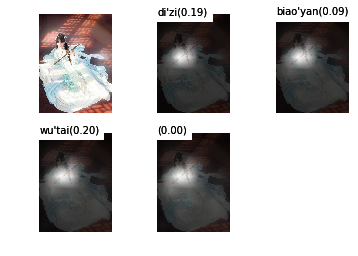

4 笛子 拉 舞台 </S> 0.0181644
probs [0.19404586777067057, 0.08848523250383318, 0.16558725653323397, 3.829001255669052e-05, 0.0]


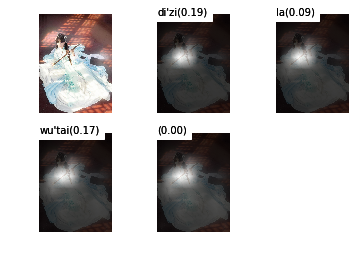

5 小提琴 拉 </S> 0.0179323
probs [0.31076324063790517, 0.08870607178099203, 0.00020918052407856725, 0.0, 0.0]


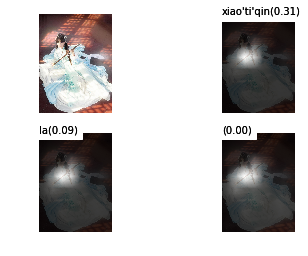

6 小提琴 表演 </S> 0.0174641
probs [0.31076324063790517, 0.09004998660923544, 0.00019033792395152093, 0.0, 0.0]


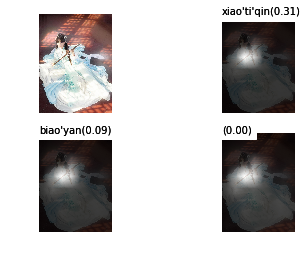

7 笛子 舞台 </S> 0.0173186
probs [0.19404586777067057, 0.08274564532893312, 0.0003235084252248877, 0.0, 0.0]


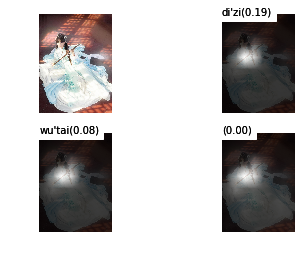

8 小提琴 舞台 表演 </S> 0.0167535
probs [0.31076324063790517, 0.08260748655078472, 0.15111783141768806, 2.030747403387959e-05, 0.0]


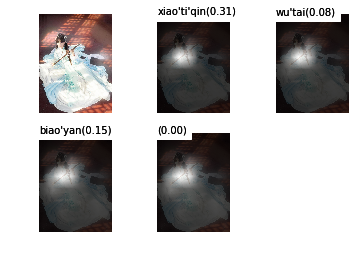

9 小提琴 古装 舞台 </S> 0.0164137
probs [0.31076324063790517, 0.047432557600693454, 0.14632603441185632, 3.365118394402523e-05, 0.0]


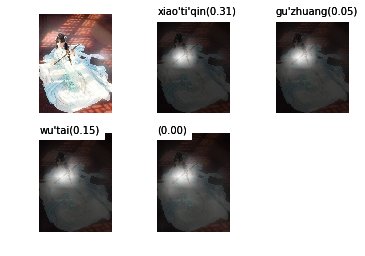

beam search using time(ms): 6361.94300652
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 4972e037e6632ecc2ef40c0d556ca993c7cea9eb


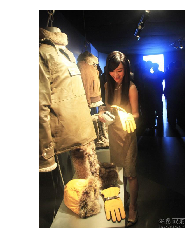

0 动物 动物 </S> 0.0324347
probs [0.17250735646216372, 0.07857605283558249, 0.002517287454216692, 0.0, 0.0]


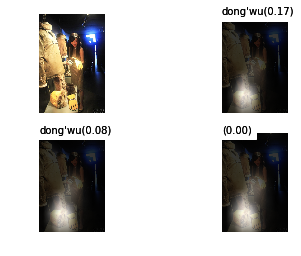

1 动物 一只 </S> 0.0303507
probs [0.17250735646216372, 0.06295220893085374, 0.0025744690767268044, 0.0, 0.0]


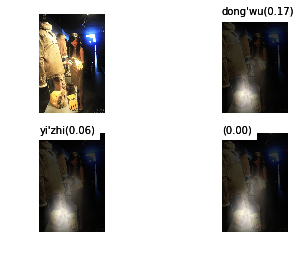

2 动物 动物 昏暗 </S> 0.026419
probs [0.17250735646216372, 0.07857605283558249, 0.0526533195320872, 0.0006825620522869588, 0.0]


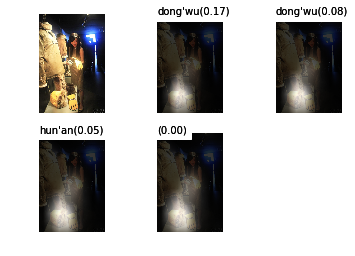

3 动物 动物 一只 </S> 0.0258319
probs [0.17250735646216372, 0.07857605283558249, 0.05528718790167981, 0.0005941588797447014, 0.0]


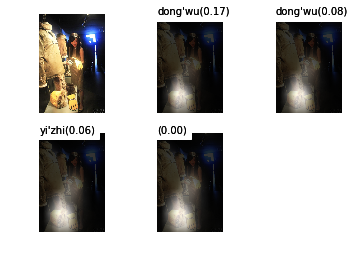

4 动物 一只 昏暗 </S> 0.0255146
probs [0.17250735646216372, 0.06295220893085374, 0.05651050743833771, 0.0006905719841844548, 0.0]


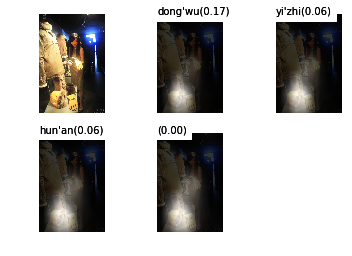

5 动物 昏暗 </S> 0.0251674
probs [0.17250735646216372, 0.029705906017777856, 0.0031107422812088107, 0.0, 0.0]


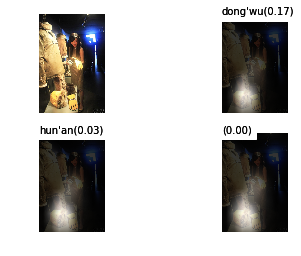

6 动物 一只 一只 </S> 0.0247325
probs [0.17250735646216372, 0.06295220893085374, 0.05746515914625715, 0.0005995789415350873, 0.0]


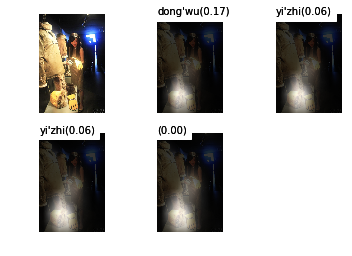

7 动物 动物 动物 </S> 0.0246147
probs [0.17250735646216372, 0.07857605283558249, 0.046541874736317816, 0.00058188605211957, 0.0]


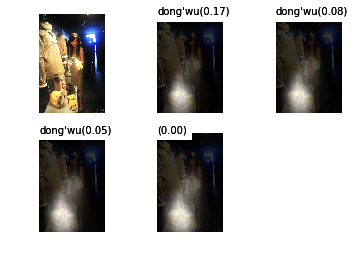

8 动物 一只 动物 </S> 0.0232029
probs [0.17250735646216372, 0.06295220893085374, 0.04548370392658264, 0.0005868042532810007, 0.0]


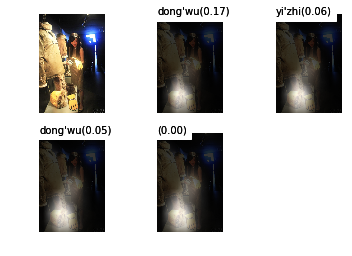

9 动物 抱 </S> 0.0231784
probs [0.17250735646216372, 0.02676956697544416, 0.002696511765609557, 0.0, 0.0]


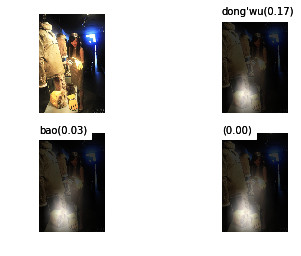

beam search using time(ms): 5408.4880352
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 1962f483a91bf9ee688ff5d8de2c74c80b7e9125


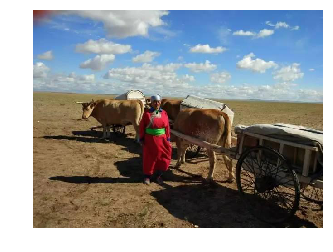

0 骆驼 沙漠 </S> 0.0796587
probs [0.4949833192446107, 0.10660307399026549, 0.009579412640045228, 0.0, 0.0]


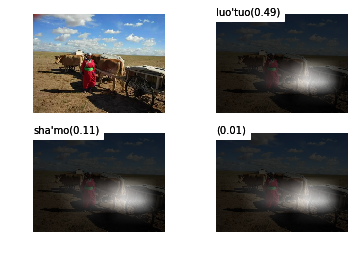

1 骆驼 驴 </S> 0.0779854
probs [0.4949833192446107, 0.10190128051169857, 0.00940305737133243, 0.0, 0.0]


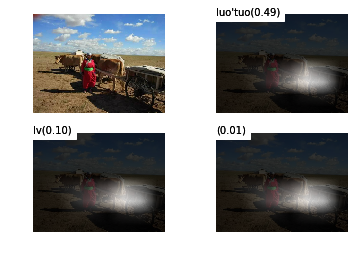

2 骆驼 骆驼 </S> 0.0762741
probs [0.4949833192446107, 0.09363837581881469, 0.009573850650730098, 0.0, 0.0]


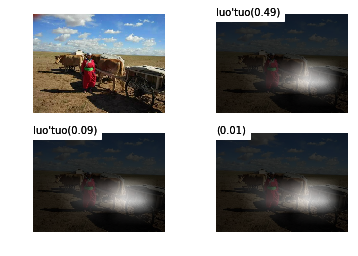

3 骆驼 沙漠 驴 </S> 0.0576791
probs [0.4949833192446107, 0.10660307399026549, 0.06208588844356633, 0.0033784761803107824, 0.0]


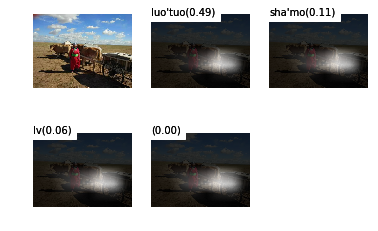

4 骆驼 驴 驴 </S> 0.0571428
probs [0.4949833192446107, 0.10190128051169857, 0.06291496767184966, 0.0033598627949199735, 0.0]


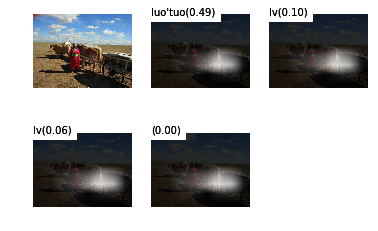

5 骆驼 马 </S> 0.0564238
probs [0.4949833192446107, 0.04111941513270093, 0.008825709113387354, 0.0, 0.0]


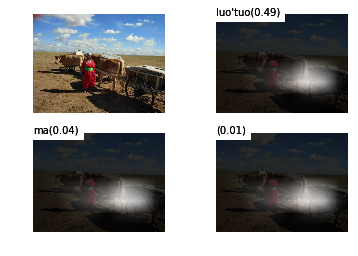

6 骆驼 骆驼 驴 </S> 0.0558829
probs [0.4949833192446107, 0.09363837581881469, 0.062283013823580244, 0.003378321529484322, 0.0]


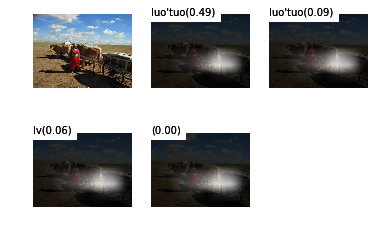

7 骆驼 沙漠 一望无际 </S> 0.0528595
probs [0.4949833192446107, 0.10660307399026549, 0.03318027761542636, 0.00445914849750642, 0.0]


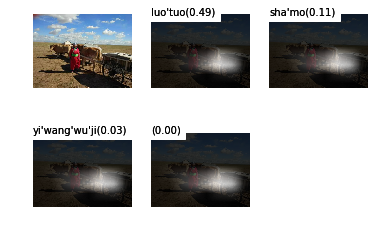

8 骆驼 沙漠 骆驼 </S> 0.0525369
probs [0.4949833192446107, 0.10660307399026549, 0.04190401919069042, 0.0034454195043497155, 0.0]


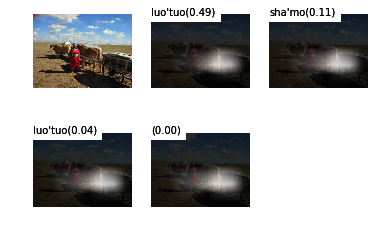

9 沙漠 沙漠 </S> 0.0522976
probs [0.13966226670747087, 0.10650732353509762, 0.009615823237245007, 0.0, 0.0]


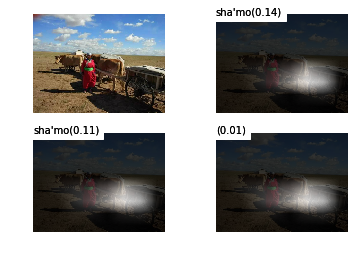

beam search using time(ms): 4115.88191986
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 0d5bb5c1fcebec433bdd5a636c85e907d0d40535


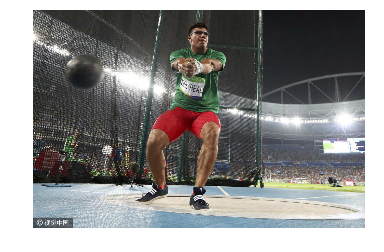

0 跑道 跑道 </S> 0.0136399
probs [0.1255885757951632, 0.15116091058333933, 0.00013367421087345216, 0.0, 0.0]


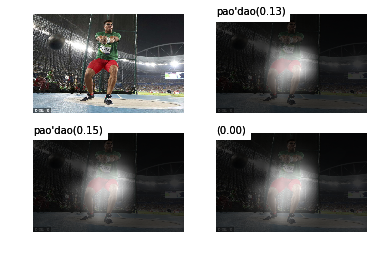

1 跑步 跑道 运动服 运动场 </S> 0.0132068
probs [0.059073572265170037, 0.23606995011907628, 0.10029832106948963, 0.14524852902357843, 1.977676598803834e-06]


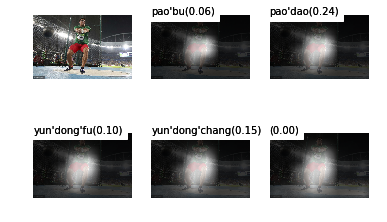

2 跑道 跑道 跑步 </S> 0.0122209
probs [0.1255885757951632, 0.15116091058333933, 0.10144802069349716, 1.158184582272631e-05, 0.0]


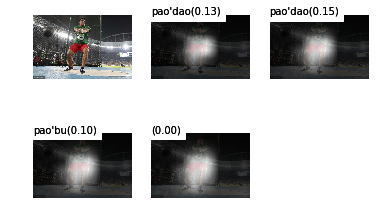

3 举重 跑道 跑步 </S> 0.0120579
probs [0.11439692896014349, 0.12751656019631513, 0.10720882885297853, 1.3516938908890784e-05, 0.0]


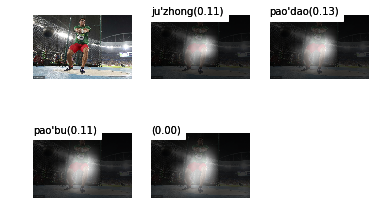

4 举重 跑道 </S> 0.0118912
probs [0.11439692896014349, 0.12751656019631513, 0.0001152647079598128, 0.0, 0.0]


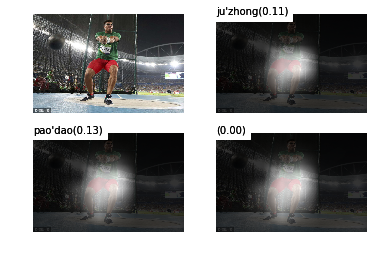

5 跑步 跑道 跑道 运动服 </S> 0.0117895
probs [0.059073572265170037, 0.23606995011907628, 0.07555507854206107, 0.09547719142955743, 2.264044430974545e-06]


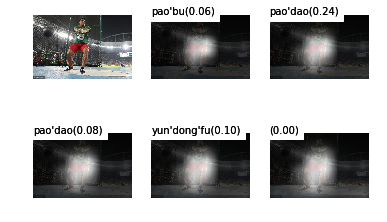

6 跑道 跑步 </S> 0.0117376
probs [0.1255885757951632, 0.10377302851696665, 0.00012407892950069724, 0.0, 0.0]


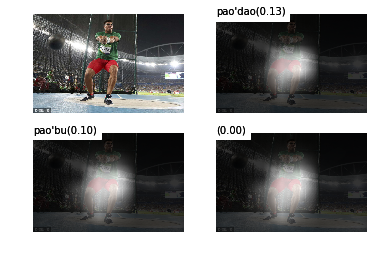

7 跑步 跑道 运动服 红色 </S> 0.0113871
probs [0.059073572265170037, 0.23606995011907628, 0.10029832106948963, 0.06898413904383138, 1.9841715126704338e-06]


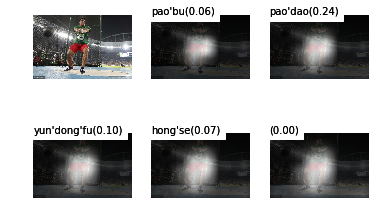

8 跑道 跑道 跑步 运动服 </S> 0.0113503
probs [0.1255885757951632, 0.15116091058333933, 0.10144802069349716, 0.06253121034546837, 1.5642441909378507e-06]


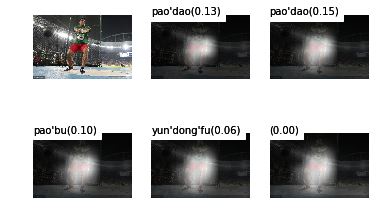

9 跑步 跑道 运动服 跑道 </S> 0.0113184
probs [0.059073572265170037, 0.23606995011907628, 0.10029832106948963, 0.07380076476999209, 1.799426414350013e-06]


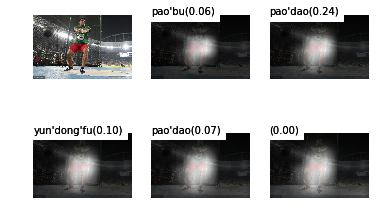

beam search using time(ms): 6412.49418259
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 601013467957beaa6f85ffbbe46b1093b764ea5c


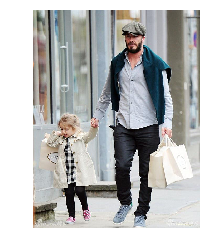

0 牵着 袋子 拎 走 </S> 0.0250755
probs [0.6807245455495938, 0.2426726529412949, 0.13029149970413254, 0.207187517950532, 2.2231947435658212e-06]


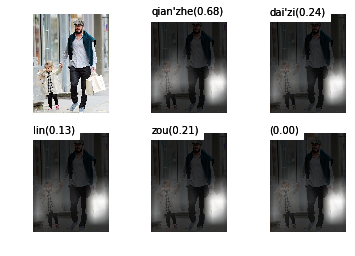

1 牵着 袋子 袋子 走 </S> 0.0247057
probs [0.6807245455495938, 0.2426726529412949, 0.1403910586945169, 0.20758965638659982, 1.9118221491870416e-06]


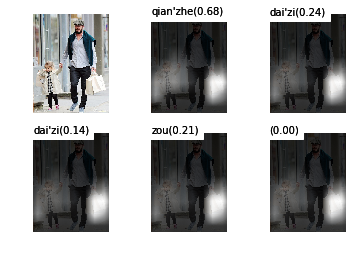

2 牵着 拎 袋子 走 </S> 0.0241774
probs [0.6807245455495938, 0.1660744527967385, 0.1563546630268524, 0.2183190711746249, 2.140753345406518e-06]


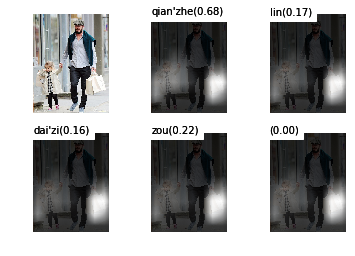

3 牵着 拎 拎 走 </S> 0.023909
probs [0.6807245455495938, 0.1660744527967385, 0.1312750111524734, 0.2164278533830608, 2.4324144199329302e-06]


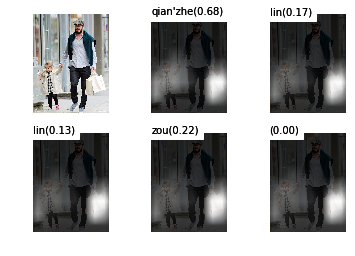

4 牵着 牵着 拎 走 </S> 0.0235268
probs [0.6807245455495938, 0.16624178731512282, 0.13174853158053243, 0.20877330795832558, 2.315710888033683e-06]


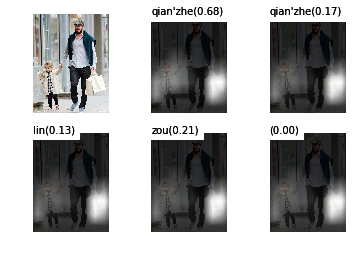

5 牵着 牵着 袋子 走 </S> 0.0232566
probs [0.6807245455495938, 0.16624178731512282, 0.14371540254706075, 0.20928058741547187, 1.9988679292075185e-06]


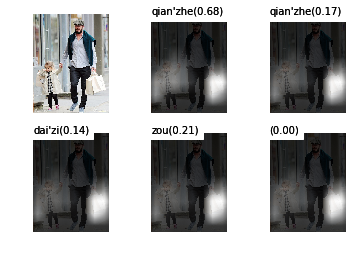

6 牵着 袋子 牵着 走 </S> 0.0221215
probs [0.6807245455495938, 0.2426726529412949, 0.0767977590166006, 0.2066586051833106, 2.0205811362196013e-06]


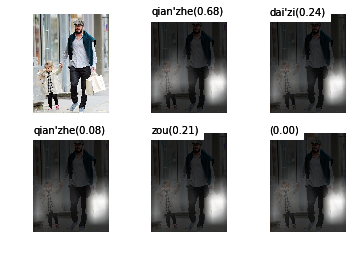

7 牵着 袋子 走 道路 </S> 0.0214279
probs [0.6807245455495938, 0.2426726529412949, 0.1168703160618705, 0.3216899916791978, 7.273911578720195e-07]


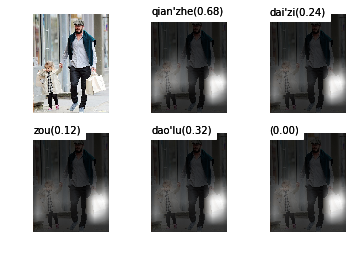

8 牵着 袋子 袋子 </S> 0.0209615
probs [0.6807245455495938, 0.2426726529412949, 0.1403910586945169, 8.324550976858366e-06, 0.0]


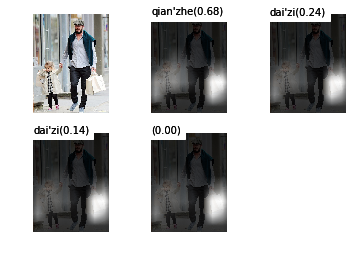

9 牵着 拎 走 道路 </S> 0.0201965
probs [0.6807245455495938, 0.1660744527967385, 0.11450992782920112, 0.3185750184409136, 8.148018416617468e-07]


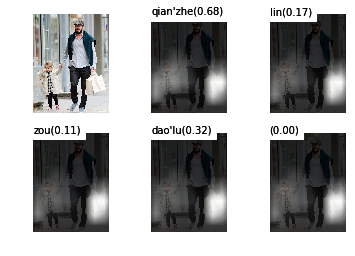

beam search using time(ms): 6416.5661335


In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: ')
  image_name = image_name.strip().replace('file://', '')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)